In [ ]:
!pip install pulp

     |████████████████████████████████| 14.2 MB 22.2 MB/s 


In [ ]:
from pulp import *
import numpy as np
import math
import prettytable as PT
import matplotlib.pyplot as plt
from prettytable import DOUBLE_BORDER


### Function For Defining Optimisation Problem

In [ ]:
def getProb(n,m,l,stages,B,SE,TC,NE,HC,CE,map,manMap):
    prob = LpProblem("The_Problem",LpMaximize)
    M = [x for x in range(m)]
    N = [x for x in range(n)]
    STAG = [x for x in range(1,stages + 1)]

    A = LpVariable.dicts('Yskz', (M,N,STAG) , cat="Binary" )
    prob += pulp.lpSum([(CE[k] + SE[k][s] + NE[k][s])*A[s][k][lamb] for k in range(n) for s in range(m) for lamb in range(1,stages + 1)])

    for lamb in range(1,stages + 1):
        prob += pulp.lpSum([(CE[k] + SE[k][s] + NE[k][s])*A[s][k][lamb] for k in range(n) for s in range(m) ] ) - pulp.lpSum([T[lamb]*manMap[s][lamb]/100 for s in range(m)]) >= 0

    prob +=  pulp.lpSum([ (HC[k] * A[s][k][lamb] * map[lamb]) for s in range(m) for lamb in range(1,stages + 1) for k in range(n)]) + pulp.lpSum( [A[s][k][lamb]*TC[k][s] for k in range(n) for s in range(m) for lamb in range(2,stages + 1) ]) <= B

    for k in range(n):
        for lamb in range(1,stages + 1):
            prob += pulp.lpSum([A[s][k][lamb] for s in range(m)]) <= 1

    for s in range(m):
        for lamb in range(1,stages + 1):
            prob += pulp.lpSum([A[s][k][lamb] for k in range(n)]) == manMap[s][lamb]

    return [prob,A]

def getProbMinBudget(n,m,l,stages,minEfficiency,SE,TC,NE,HC,CE,map,manMap):
    prob = LpProblem("The_Problem",LpMinimize)
    M = [x for x in range(m)]
    N = [x for x in range(n)]
    STAG = [x for x in range(1,stages + 1)]

    A = LpVariable.dicts('Yskz', (M,N,STAG) , cat="Binary" )

    prob += pulp.lpSum([ (HC[k]*A[s][k][lamb]*map[lamb]) for s in range(m) for lamb in range(1,stages + 1) for k in range(n)])
    
    for lamb in range(1,stages + 1):
        prob += pulp.lpSum([(CE[k] + SE[k][s] + NE[k][s])*A[s][k][lamb] for k in range(n) for s in range(m) ] ) - pulp.lpSum([T[lamb]*manMap[s][lamb]/100 for s in range(m)]) >= 0

    prob += pulp.lpSum([(CE[k] + SE[k][s] + NE[k][s])*A[s][k][lamb] for k in range(n) for s in range(m) for lamb in range(1,stages + 1)]) >= minEfficiency

    for k in range(n):
        for lamb in range(1,stages + 1):
            prob += pulp.lpSum([A[s][k][lamb] for s in range(m)]) <= 1

    for s in range(m):
        for lamb in range(1,stages + 1):
            prob += pulp.lpSum([A[s][k][lamb] for k in range(n)]) == manMap[s][lamb]

    return [prob,A]

### Global Variables

In [ ]:
m = 5
n = 12
l = 471
stages = 7

SE = [[] for i in range(n)]
TC = [[] for i in range(n)]
NE = [[] for i in range(n)]
HC = []
CE = []

file = open('/content/data.txt')

j = 0
for line in file.readlines():
    arr = line.split()
    for i in range(len(arr)):
        if(i%3 == 0):
            SE[j].append(float(arr[i]))
        elif(i%3 == 1):
            TC[j].append(float(arr[i]))
        elif(i%3 == 2):
            NE[j].append(float(arr[i]))
    j += 1

file.close()


file = open('/content/data1.txt')
j = 0
for line in file.readlines():
    arr = line.split()
    HC.append(float(arr[0]))
    CE.append(float(arr[1]))
    j += 1
file.close()

map = np.zeros((8), dtype = np.float32)
map[1] = 0.33
map[2] = 0.5
map[3] = 2
map[4] = 3
map[5] = 7
map[6] = 2
map[7] = 1.5

manMap = [[0 for y in range(0,stages+1)] for x in range(m)]

manMap[0][1] = 1
manMap[0][2] = 1
manMap[0][7] = 1
manMap[1][3] = 4
manMap[1][4] = 2
manMap[1][5] = 4
manMap[1][6] = 2
manMap[1][7] = 4
manMap[2][4] = 2
manMap[2][5] = 2
manMap[3][5] = 4
manMap[4][6] = 4

T = [0,70,50,300,310,760,460,350]

### Maximise Efficiency Without Budget Limit

In [ ]:
B = 600000000000
prob,A = getProb(n,m,l,stages,B,SE,TC,NE,HC,CE,map,manMap)

prob.solve()
print("Status:", LpStatus[prob.status])
print("Eficiency:", prob.objective.value())

budgetUsed = 0

for k in range(n) :
  for lamb in range(1,stages + 1) :
    for s in range(m) :
      budgetUsed += pulp.lpSum( HC[k] * A[s][k][lamb].varValue *map[lamb]) 

for k in range(n) :
  for s in range(m) :
    for lamb in range(1,stages) :
      budgetUsed += TC[k][s]*A[s][k][lamb].varValue*(1 - A[s][k][lamb + 1].varValue)

print("Budget:",  int(budgetUsed.value()))

toPrint = [[[] for s in range(m)] for x in range(0,stages + 1)]

for lamb in range(1,stages + 1):
    for s in range(m):
        for k in range(n):
            if(int(A[s][k][lamb].varValue) == 1):
                toPrint[lamb][s].append(k)

myTable = PT.PrettyTable(["Stage Of Project","PM","SA","SD","PG","QA"])
myTable.set_style(DOUBLE_BORDER)

for x in range(1,stages+1):
    tmp = [x]
    tmp.extend(toPrint[x])
    for i in range(1,m+1):
        tmp[i] = " ".join([chr(tmp[i][j] + ord('A')) for j in range(len(tmp[i]))])
    if(len(tmp) != 0):
        myTable.add_row(tmp)

print(myTable)

Status: Optimal
Eficiency: 3430.5
Budget: 6594954
╔══════════════════╦════╦═════════╦═════╦═════════╦═════════╗
║ Stage Of Project ║ PM ║    SA   ║  SD ║    PG   ║    QA   ║
╠══════════════════╬════╬═════════╬═════╬═════════╬═════════╣
║        1         ║ A  ║         ║     ║         ║         ║
║        2         ║ A  ║         ║     ║         ║         ║
║        3         ║    ║ A B C J ║     ║         ║         ║
║        4         ║    ║   A C   ║ F J ║         ║         ║
║        5         ║    ║ A B C G ║ D J ║ E F H K ║         ║
║        6         ║    ║   A C   ║     ║         ║ B H I J ║
║        7         ║ I  ║ A B C J ║     ║         ║         ║
╚══════════════════╩════╩═════════╩═════╩═════════╩═════════╝


### Maximise Efficiency With Budget Limit

In [ ]:
B = 6000000
prob,A = getProb(n,m,l,stages,B,SE,TC,NE,HC,CE,map,manMap)

prob.solve()
print("Status:", LpStatus[prob.status])
print("Eficiency:", prob.objective.value())

budgetUsed = 0

for k in range(n) :
  for lamb in range(1,stages + 1) :
    for s in range(m) :
      budgetUsed += pulp.lpSum( HC[k] * A[s][k][lamb].varValue *map[lamb]) 

for k in range(n) :
  for s in range(m) :
    for lamb in range(1,stages) :
      budgetUsed += TC[k][s]*A[s][k][lamb].varValue*(1 - A[s][k][lamb + 1].varValue)

print("Budget:",  int(budgetUsed.value()))

toPrint = [[[] for s in range(m)] for x in range(0,stages + 1)]

for lamb in range(1,stages + 1):
    for s in range(m):
        for k in range(n):
            if(int(A[s][k][lamb].varValue) == 1):
                toPrint[lamb][s].append(k)

myTable = PT.PrettyTable(["Stage Of Project","PM","SA","SD","PG","QA"])
myTable.set_style(DOUBLE_BORDER)

for x in range(1,stages+1):
    tmp = [x]
    tmp.extend(toPrint[x])
    for i in range(1,m+1):
        tmp[i] = " ".join([chr(tmp[i][j] + ord('A')) for j in range(len(tmp[i]))])
    if(len(tmp) != 0):
        myTable.add_row(tmp)

print(myTable)

Status: Optimal
Eficiency: 3013.5
Budget: 5999094
╔══════════════════╦════╦═════════╦═════╦═════════╦═════════╗
║ Stage Of Project ║ PM ║    SA   ║  SD ║    PG   ║    QA   ║
╠══════════════════╬════╬═════════╬═════╬═════════╬═════════╣
║        1         ║ A  ║         ║     ║         ║         ║
║        2         ║ A  ║         ║     ║         ║         ║
║        3         ║    ║ C G H J ║     ║         ║         ║
║        4         ║    ║   C G   ║ D H ║         ║         ║
║        5         ║    ║ B C G I ║ D J ║ E H K L ║         ║
║        6         ║    ║   C D   ║     ║         ║ G H I J ║
║        7         ║ I  ║ B C G J ║     ║         ║         ║
╚══════════════════╩════╩═════════╩═════╩═════════╩═════════╝


### Maximise Efficiency Without Budget, CE and NE

In [ ]:
NE1 = [[0 for j in range(m)] for i in range(n)]
CE1 = [0 for j in range(n)]
B = 60000000000000
prob,A = getProb(n,m,l,stages,B,SE,TC,NE1,HC,CE1,map,manMap)

prob.solve()
print("Status:", LpStatus[prob.status])
print("Eficiency:", prob.objective.value())

budgetUsed = 0

for k in range(n) :
  for lamb in range(1,stages + 1) :
    for s in range(m) :
      budgetUsed += pulp.lpSum( HC[k] * A[s][k][lamb].varValue *map[lamb]) 

for k in range(n) :
  for s in range(m) :
    for lamb in range(1,stages) :
      budgetUsed += TC[k][s]*A[s][k][lamb].varValue*(1 - A[s][k][lamb + 1].varValue)

print("Budget:",  int(budgetUsed.value()))

toPrint = [[[] for s in range(m)] for x in range(0,stages + 1)]

for lamb in range(1,stages + 1):
    for s in range(m):
        for k in range(n):
            if(int(A[s][k][lamb].varValue) == 1):
                toPrint[lamb][s].append(k)

myTable = PT.PrettyTable(["Stage Of Project","PM","SA","SD","PG","QA"])
myTable.set_style(DOUBLE_BORDER)

for x in range(1,stages+1):
    tmp = [x]
    tmp.extend(toPrint[x])
    for i in range(1,m+1):
        tmp[i] = " ".join([chr(tmp[i][j] + ord('A')) for j in range(len(tmp[i]))])
    if(len(tmp) != 0):
        myTable.add_row(tmp)

print(myTable)

Status: Optimal
Eficiency: 2735.0
Budget: 6657948
╔══════════════════╦════╦═════════╦═════╦═════════╦═════════╗
║ Stage Of Project ║ PM ║    SA   ║  SD ║    PG   ║    QA   ║
╠══════════════════╬════╬═════════╬═════╬═════════╬═════════╣
║        1         ║ A  ║         ║     ║         ║         ║
║        2         ║ A  ║         ║     ║         ║         ║
║        3         ║    ║ A B C J ║     ║         ║         ║
║        4         ║    ║   A C   ║ D F ║         ║         ║
║        5         ║    ║ A B C G ║ D J ║ E F K L ║         ║
║        6         ║    ║   A C   ║     ║         ║ B H I J ║
║        7         ║ I  ║ A B C J ║     ║         ║         ║
╚══════════════════╩════╩═════════╩═════╩═════════╩═════════╝


### Minimise Budget With given Efficiency

In [ ]:
minEfficiency = 2500
prob,A = getProbMinBudget(n,m,l,stages,minEfficiency,SE,TC,NE,HC,CE,map,manMap)

prob.solve()
print("Status:", LpStatus[prob.status])
print("Budget:", int(prob.objective.value()))

effGot = pulp.lpSum([(CE[k] + SE[k][s] + NE[k][s])*A[s][k][lamb].varValue for k in range(n) for s in range(m) for lamb in range(1,stages + 1)])

print("Eficiency:",  int(effGot.value()))

toPrint = [[[] for s in range(m)] for x in range(0,stages + 1)]

for lamb in range(1,stages + 1):
    for s in range(m):
        for k in range(n):
            if(int(A[s][k][lamb].varValue) == 1):
                toPrint[lamb][s].append(k)

myTable = PT.PrettyTable(["Stage Of Project","PM","SA","SD","PG","QA"])
myTable.set_style(DOUBLE_BORDER)

for x in range(1,stages+1):
    tmp = [x]
    tmp.extend(toPrint[x])
    for i in range(1,m+1):
        tmp[i] = " ".join([chr(tmp[i][j] + ord('A')) for j in range(len(tmp[i]))])
    if(len(tmp) != 0):
        myTable.add_row(tmp)

print(myTable)

Status: Optimal
Budget: 5786330
Eficiency: 2501
╔══════════════════╦════╦═════════╦═════╦═════════╦═════════╗
║ Stage Of Project ║ PM ║    SA   ║  SD ║    PG   ║    QA   ║
╠══════════════════╬════╬═════════╬═════╬═════════╬═════════╣
║        1         ║ I  ║         ║     ║         ║         ║
║        2         ║ I  ║         ║     ║         ║         ║
║        3         ║    ║ D G H I ║     ║         ║         ║
║        4         ║    ║   G I   ║ D H ║         ║         ║
║        5         ║    ║ B C G I ║ D J ║ E H K L ║         ║
║        6         ║    ║   D E   ║     ║         ║ G H I K ║
║        7         ║ I  ║ D E G H ║     ║         ║         ║
╚══════════════════╩════╩═════════╩═════╩═════════╩═════════╝


### Minimise Budget Without Efficiency Constraint 

In [ ]:
minEfficiency = 0
prob,A = getProbMinBudget(n,m,l,stages,minEfficiency,SE,TC,NE,HC,CE,map,manMap)

prob.solve()
print("Status:", LpStatus[prob.status])
print("Budget:", int(prob.objective.value()))

effGot = pulp.lpSum([(CE[k] + SE[k][s] + NE[k][s])*A[s][k][lamb].varValue for k in range(n) for s in range(m) for lamb in range(1,stages + 1)])

print("Eficiency:",  int(effGot.value()))

toPrint = [[[] for s in range(m)] for x in range(0,stages + 1)]

for lamb in range(1,stages + 1):
    for s in range(m):
        for k in range(n):
            if(int(A[s][k][lamb].varValue) == 1):
                toPrint[lamb][s].append(k)

myTable = PT.PrettyTable(["Stage Of Project","PM","SA","SD","PG","QA"])
myTable.set_style(DOUBLE_BORDER)

for x in range(1,stages+1):
    tmp = [x]
    tmp.extend(toPrint[x])
    for i in range(1,m+1):
        tmp[i] = " ".join([chr(tmp[i][j] + ord('A')) for j in range(len(tmp[i]))])
    if(len(tmp) != 0):
        myTable.add_row(tmp)

print(myTable)

Status: Optimal
Budget: 5778860
Eficiency: 1994
╔══════════════════╦════╦═════════╦═════╦═════════╦═════════╗
║ Stage Of Project ║ PM ║    SA   ║  SD ║    PG   ║    QA   ║
╠══════════════════╬════╬═════════╬═════╬═════════╬═════════╣
║        1         ║ G  ║         ║     ║         ║         ║
║        2         ║ G  ║         ║     ║         ║         ║
║        3         ║    ║ D G H I ║     ║         ║         ║
║        4         ║    ║   D G   ║ H I ║         ║         ║
║        5         ║    ║ G I K L ║ D J ║ B C E H ║         ║
║        6         ║    ║   E K   ║     ║         ║ D G H I ║
║        7         ║ E  ║ D G H I ║     ║         ║         ║
╚══════════════════╩════╩═════════╩═════╩═════════╩═════════╝


### Minimise Budget Without NE CE

In [ ]:
minEfficiency = 2200
NE1 = [[0 for j in range(m)] for i in range(n)]
CE1 = [0 for j in range(n)]

prob,A = getProbMinBudget(n,m,l,stages,minEfficiency,SE,TC,NE1,HC,CE1,map,manMap)

prob.solve()
print("Status:", LpStatus[prob.status])
print("Budget:", int(prob.objective.value()))

effGot = pulp.lpSum([(CE1[k] + SE[k][s] + NE1[k][s])*A[s][k][lamb].varValue for k in range(n) for s in range(m) for lamb in range(1,stages + 1)])

print("Eficiency:",  int(effGot.value()))

toPrint = [[[] for s in range(m)] for x in range(0,stages + 1)]

for lamb in range(1,stages + 1):
    for s in range(m):
        for k in range(n):
            if(int(A[s][k][lamb].varValue) == 1):
                toPrint[lamb][s].append(k)

myTable = PT.PrettyTable(["Stage Of Project","PM","SA","SD","PG","QA"])
myTable.set_style(DOUBLE_BORDER)

for x in range(1,stages+1):
    tmp = [x]
    tmp.extend(toPrint[x])
    for i in range(1,m+1):
        tmp[i] = " ".join([chr(tmp[i][j] + ord('A')) for j in range(len(tmp[i]))])
    if(len(tmp) != 0):
        myTable.add_row(tmp)

print(myTable)

Status: Optimal
Budget: 5862600
Eficiency: 2200
╔══════════════════╦════╦═════════╦═════╦═════════╦═════════╗
║ Stage Of Project ║ PM ║    SA   ║  SD ║    PG   ║    QA   ║
╠══════════════════╬════╬═════════╬═════╬═════════╬═════════╣
║        1         ║ A  ║         ║     ║         ║         ║
║        2         ║ I  ║         ║     ║         ║         ║
║        3         ║    ║ D E G H ║     ║         ║         ║
║        4         ║    ║   G H   ║ D E ║         ║         ║
║        5         ║    ║ B C G I ║ D J ║ E H K L ║         ║
║        6         ║    ║   C D   ║     ║         ║ G H I K ║
║        7         ║ I  ║ C D E G ║     ║         ║         ║
╚══════════════════╩════╩═════════╩═════╩═════════╩═════════╝


### Plot Trade-Off

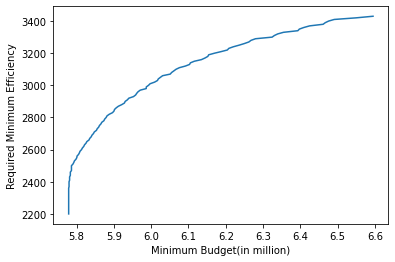

In [ ]:
eff = range(2200,3431,10)
bud = []
for x in eff:
    prob,A = getProbMinBudget(n,m,l,stages,x,SE,TC,NE,HC,CE,map,manMap)
    prob.solve()
    bud.append(prob.objective.value()/1000000)
plt.ylabel('Required Minimum Efficiency')
plt.xlabel('Minimum Budget(in million)')
plt.plot(bud,eff)

Text(0.5, 0, 'Budget(in million) Allocated')

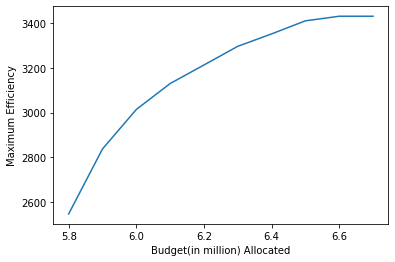

In [ ]:
bud1 = range(5800000,6700001,100000)
eff1 = []
for x in bud1:
    prob,A = getProb(n,m,l,stages,x,SE,TC,NE,HC,CE,map,manMap)
    prob.solve()
    eff1.append(prob.objective.value())

bud1 = [x/1000000 for x in bud1]
plt.plot(bud1,eff1)
plt.ylabel('Maximum Efficiency')
plt.xlabel('Budget(in million) Allocated')

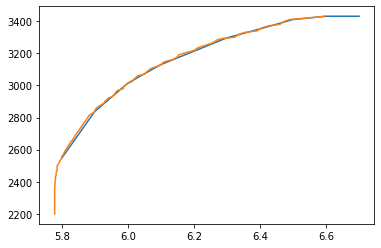

In [ ]:
plt.plot(bud1,eff1)
plt.plot(bud,eff)

### Get Best Value For Money

In [ ]:
def getTradeOff(ratio):
    prob,A = getProb(n,m,l,stages,600000000000,SE,TC,NE,HC,CE,map,manMap)
    prob.solve()
    maxEff = prob.objective.value()

    prob,A = getProbMinBudget(n,m,l,stages,0,SE,TC,NE,HC,CE,map,manMap)
    prob.solve()
    minEff = sum([(CE1[k] + SE[k][s] + NE1[k][s])*A[s][k][lamb].varValue for k in range(n) for s in range(m) for lamb in range(1,stages + 1)])
    minBud = prob.objective.value()

    eff = list(range(int(minEff) + 1,int(maxEff),5))
    bud = []
    for x in eff:
        prob,A = getProbMinBudget(n,m,l,stages,x,SE,TC,NE,HC,CE,map,manMap)
        prob.solve()
        bud.append(prob.objective.value()/1000000)
    
    k = 0
    linex = [bud[0]]
    liney = [eff[0]]
    for i in range(1,len(bud)):
         linex.append(bud[i])
         liney.append(liney[i-1] + liney[0] * ratio * (linex[i] - linex[0])/linex[0])
         if(eff[i] >= liney[i]):
             k = i

    print("Best Trade-Off Budget (in millions): ", round(bud[k],3))
    print("Corresponding Efficiency: ", eff[k])   

    plt.ylim([eff[0],eff[-1]])
    plt.ylabel('Maximum Efficiency')
    plt.xlabel('Budget(in million)')
    plt.plot(bud,eff,label = 'Real')
    plt.plot(linex,liney,label='Simulated')
    plt.legend()

Best Trade-Off Budget (in millions):  5.918
Corresponding Efficiency:  2876


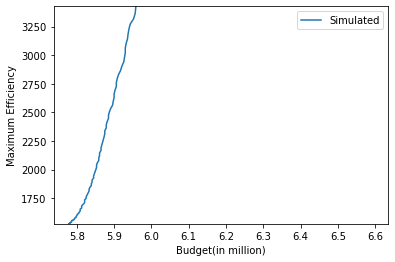

In [ ]:
getTradeOff(1)